In [1]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from resnet_models import*
import utils
from utils import*
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import TensorDataset
import mlp_private
from mlp_private import*
from dataset import BBoxDtaset
import cv2
from torch.utils.data.sampler import SubsetRandomSampler
import nni
from nni.compression.torch import LevelPruner, L1FilterPruner, FPGMPruner, SlimPruner
# from vgg_models import*
from sklearn.metrics import *
import itertools

In [2]:
#Hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 100
train_batch_size = 128
test_batch_size = 100
learning_rate = 0.001
momentum = 0.9
original_classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
watermark_classes = ('no key', 'top righ', 'top left', 'down right', 'dwon left')
identity_string = b'Y6588121SNAJEEBMOHARRAMSALIMJEBREEL02092020imageclassification_10_classes'
fake_identity_string = b'Y6588121NAJEEBMOHARRAMSALIMcrisesURV02092020classification10labels'
plagiarizer_identity_string = b'X7823579MRAMIJOSEPHAFFARcrisesURV2409022ResNet18classification10labels'
plagiarizer_fake_identity_string = b'X7823579WRAMIHAFFARJOSEP2509022ResNet18classificationofImage10labels'
key_size = 5
num_wm_samples = 25000
train_wm_black_box_epochs = 50
combined_original_model_epochs = 200
combined_private_model_epochs = 100
train_simultaneously_epochs = 100
dataset = 'cifar10'
containerdataset = 'stl10'

In [ ]:
# Testing the original model on the original task
def test_original_only(model, criterion, test_loader, device):
   
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets, flags) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs= model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            print('Testing: epoch: %d | loss: %.3f | Acc: %.3f' %(1, test_loss/(batch_idx+1), 100.*correct/total))
            
        return  test_loss/(batch_idx+1), 100.*correct/total

In [ ]:
# Testing the original model on the original task
def test_original(model, criterion, test_loader, device):
   
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets, flags) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            print('Testing: epoch: %d | loss: %.3f | Acc: %.3f' %(1, test_loss/(batch_idx+1), 100.*correct/total))
            
        return  test_loss/(batch_idx+1), 100.*correct/total

In [ ]:
# Testing the private model on the wm task
def test_private(model, criterion, test_loader, device):
   
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets, flags) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.type(torch.LongTensor).to(device)
                _, outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            print('Private model testing: epoch: %d | loss: %.3f | Acc: %.3f' %(1, test_loss/(batch_idx+1), 100.*correct/total))
            
            return  test_loss/(batch_idx+1), 100.*correct/total

In [ ]:
# Testing the private model on the wm task
def test_private_part(model, criterion, test_loader, device):
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets, flags) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.type(torch.LongTensor).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

            print('Testing: epoch: %d | loss: %.3f | Acc: %.3f' %(1, test_loss/(batch_idx+1), 100.*correct/total))
            
        return  test_loss/(batch_idx+1), 100.*correct/total

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Test label predictions
def test_label_predictions_combined(test_loader, model, device):
    model.eval()
    actuals = []
    predictions = []

    with torch.no_grad():
         for batch_idx, (inputs, targets, flags) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.type(torch.LongTensor).squeeze().to(device)
            _, outputs = model(inputs)
            outputs = outputs.squeeze()
            prediction = outputs.argmax(dim=1, keepdim=True)
            actuals.extend(targets.view_as(prediction))
            predictions.extend(prediction)

    actuals =  [i.item() for i in actuals]
    predictions = [i.item() for i in predictions]
    print('Confusion matrix:')
    cnf_matrix = confusion_matrix(actuals, predictions)
    print(cnf_matrix)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[str(i) for i in range(6)], normalize=True,
                      title='With predictions of unmarked VGG16')
    plt.tight_layout()
    plt.savefig('private_resnet18_with_unmarked_vgg16.png', dpi = 600)
    plt.show()
    print('F1 score: %f' % accuracy_score(actuals, predictions))

    print('{0:10s} - {1}'.format('Category','Accuracy'))
    for i, r in enumerate(confusion_matrix(actuals, predictions)):
        print('{0:10s} - {1:.1f}'.format(str(i), r[i]/np.sum(r)*100))


In [ ]:
""" get the outputs of the original model to use them as input feature to the private model 
    that will be trained in a blackbox setting. """
def get_original_model_outputs(model, dataloader, device):
        model.eval()
        features = []
        labels = []
        with torch.no_grad():
            for batch_idx, (inputs, targets, flags) in enumerate(dataloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                features.append(outputs)
                labels.append(targets)
    
        return features, labels

In [ ]:
""" get the outputs of the original model to use them as input feature to the private model 
    that will be trained in a blackbox setting. """
def get_wm_model_outputs(model, dataloader, device):
        model.eval()
        features = []
        labels = []
        with torch.no_grad():
            for batch_idx, (inputs, targets, flags) in enumerate(dataloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                features.append(outputs[0])
                labels.append(targets)
    
        return features, labels

In [ ]:
#load original dataset

trainset, testset, train_loader, test_loader = get_flagged_cifar10_dataset(100, 100)
random_samples = np.random.choice(len(trainset), int(len(trainset)*1), replace = False)
sampled_trainset = torch.utils.data.Subset(trainset, random_samples)
finetune_train_loader = torch.utils.data.DataLoader(
        sampled_trainset, batch_size=100, shuffle=True, num_workers=2)


In [ ]:
# load watermark dataset

trainsetwm, testsetwm = get_signed_dataset(identity_string, fake_identity_string, key_size, num_wm_samples
                                          , containerdataset=containerdataset)
wm_testloader = torch.utils.data.DataLoader(testsetwm, batch_size=10, shuffle=False, num_workers=1)


# wm_testloader = torch.utils.data.DataLoader(
#         trainsetwm, batch_size=10, shuffle=False, num_workers=1)

In [ ]:
#Loading of models
criterion = nn.CrossEntropyLoss()

resnet18 = ResNet18().to(device)
checkpoint = torch.load('./Checkpoints/best_original_cifar10.t7')
resnet18.load_state_dict(checkpoint['state_dict'])

resnet18wm = ResNet18WM().to(device)
checkpoint = torch.load('./Checkpoints/best_combined_fromscratch_cifar10.t7')
resnet18wm.load_state_dict(checkpoint['state_dict'])

vgg16 = VGG('VGG16').to(device)
checkpoint = torch.load('./Checkpoints/best_original_cifar10vgg16.t7')
vgg16.load_state_dict(checkpoint['state_dict'])

vgg16wm = VGGWM('VGG16').to(device)
checkpoint = torch.load('./Checkpoints/best_combined_fromscratch_cifar10vgg16.t7')
vgg16wm.load_state_dict(checkpoint['state_dict'])


In [ ]:
# test_original(resnet18wm, criterion, test_loader, device)
test_private(resnet18wm, criterion, wm_testloader, device) 
test_label_predictions_combined(wm_testloader, resnet18wm, device)

In [ ]:
# test_original(vgg16wm, criterion, test_loader, device)
test_private(vgg16wm, criterion, wm_testloader, device) 
test_label_predictions_combined(wm_testloader, vgg16wm, device)

In [ ]:
#Integrity experiments

#1. Testing the private model trained with marked resnet18 with other unmarked resnet18
print('Testing the private model trained with marked resnet18 with other unmarked resnet18')
resnet18_dict = resnet18.state_dict()
resnet18wm_dict = resnet18wm.state_dict()
for key in resnet18_dict.keys():
    resnet18wm_dict[key] = copy.deepcopy(resnet18_dict[key])

resnet18wm.load_state_dict(resnet18wm_dict)
# test_original(resnet18wm, criterion, test_loader, device)
test_private(resnet18wm, criterion, wm_testloader, device) 
test_label_predictions_combined(wm_testloader, resnet18wm, device)

In [ ]:
#Loading of models
criterion = nn.CrossEntropyLoss()

resnet18 = ResNet18().to(device)
checkpoint = torch.load('./Checkpoints/best_original_cifar10.t7')
resnet18.load_state_dict(checkpoint['state_dict'])

resnet18wm = ResNet18WM().to(device)
checkpoint = torch.load('./Checkpoints/best_combined_fromscratch_cifar10.t7')
resnet18wm.load_state_dict(checkpoint['state_dict'])

vgg16 = VGG('VGG16').to(device)
checkpoint = torch.load('./Checkpoints/best_original_cifar10vgg16.t7')
vgg16.load_state_dict(checkpoint['state_dict'])

vgg16wm = VGGWM('VGG16').to(device)
checkpoint = torch.load('./Checkpoints/best_combined_fromscratch_cifar10vgg16.t7')
vgg16wm.load_state_dict(checkpoint['state_dict'])

In [ ]:
#2. Testing the private model trained with marked resnet18 with other unmarked vgg16
print('Testing the private model trained with marked resnet18 with other unmarked vgg16')
vgg16_dict = vgg16.state_dict()
vgg16wm_dict = vgg16wm.state_dict()
resnet18wm_dict = resnet18wm.state_dict()


vgg16wm_dict['wmlinear1.weight'] = copy.deepcopy(resnet18wm_dict['wmlayer1.weight'])
vgg16wm_dict['wmlinear2.weight'] = copy.deepcopy(resnet18wm_dict['wmlayer2.weight'])
vgg16wm_dict['wmlinear3.weight'] = copy.deepcopy(resnet18wm_dict['wmlayer3.weight'])
vgg16wm_dict['wmlinear1.bias'] = copy.deepcopy(resnet18wm_dict['wmlayer1.bias'])
vgg16wm_dict['wmlinear2.bias'] = copy.deepcopy(resnet18wm_dict['wmlayer2.bias'])
vgg16wm_dict['wmlinear3.bias'] = copy.deepcopy(resnet18wm_dict['wmlayer3.bias'])
 

for key in vgg16_dict.keys():
    vgg16wm_dict[key] = copy.deepcopy(vgg16_dict[key])

vgg16wm.load_state_dict(vgg16wm_dict)
# test_original(vgg16wm, criterion, test_loader, device)
test_private(vgg16wm, criterion, wm_testloader, device) 
test_label_predictions_combined(wm_testloader, vgg16wm, device)

In [ ]:
#Loading of models
criterion = nn.CrossEntropyLoss()

resnet18 = ResNet18().to(device)
checkpoint = torch.load('./Checkpoints/best_original_cifar10.t7')
resnet18.load_state_dict(checkpoint['state_dict'])

resnet18wm = ResNet18WM().to(device)
checkpoint = torch.load('./Checkpoints/best_combined_fromscratch_cifar10.t7')
resnet18wm.load_state_dict(checkpoint['state_dict'])

vgg16 = VGG('VGG16').to(device)
checkpoint = torch.load('./Checkpoints/best_original_cifar10vgg16.t7')
vgg16.load_state_dict(checkpoint['state_dict'])

vgg16wm = VGGWM('VGG16').to(device)
checkpoint = torch.load('./Checkpoints/best_combined_fromscratch_cifar10vgg16.t7')
vgg16wm.load_state_dict(checkpoint['state_dict'])

In [ ]:
#3. Testing the private model trained with marked vgg16 with other unmarked vgg16
print('Testing the private model trained with marked vgg16 with other unmarked vgg16')
vgg16_dict = vgg16.state_dict()
vgg16wm_dict = vgg16wm.state_dict()
for key in vgg16_dict.keys():
    vgg16wm_dict[key] = copy.deepcopy(vgg16_dict[key])

vgg16wm.load_state_dict(vgg16wm_dict)
# test_original(vgg16wm, criterion, test_loader, device)
test_private(vgg16wm, criterion, wm_testloader, device) 
test_label_predictions_combined(wm_testloader, vgg16wm, device)

In [ ]:
#Loading of models
criterion = nn.CrossEntropyLoss()

resnet18 = ResNet18().to(device)
checkpoint = torch.load('./Checkpoints/best_original_cifar10.t7')
resnet18.load_state_dict(checkpoint['state_dict'])

resnet18wm = ResNet18WM().to(device)
checkpoint = torch.load('./Checkpoints/best_combined_fromscratch_cifar10.t7')
resnet18wm.load_state_dict(checkpoint['state_dict'])

vgg16 = VGG('VGG16').to(device)
checkpoint = torch.load('./Checkpoints/best_original_cifar10vgg16.t7')
vgg16.load_state_dict(checkpoint['state_dict'])

vgg16wm = VGGWM('VGG16').to(device)
checkpoint = torch.load('./Checkpoints/best_combined_fromscratch_cifar10vgg16.t7')
vgg16wm.load_state_dict(checkpoint['state_dict'])

In [ ]:
#2. Testing the private model trained with marked vgg16 with other unmarked resnet18
print('Testing the private model trained with marked vgg16 with other unmarked resnet18')

vgg16wm_dict = vgg16wm.state_dict()
resnet18_dict = resnet18.state_dict()
resnet18wm_dict = resnet18wm.state_dict()



resnet18wm_dict['wmlayer1.weight'] = copy.deepcopy(vgg16wm_dict['wmlinear1.weight'])
resnet18wm_dict['wmlayer2.weight'] = copy.deepcopy(vgg16wm_dict['wmlinear2.weight'])
resnet18wm_dict['wmlayer3.weight'] = copy.deepcopy(vgg16wm_dict['wmlinear3.weight'])
resnet18wm_dict['wmlayer1.bias'] = copy.deepcopy(vgg16wm_dict['wmlinear1.bias'])
resnet18wm_dict['wmlayer2.bias'] = copy.deepcopy(vgg16wm_dict['wmlinear2.bias'])
resnet18wm_dict['wmlayer3.bias'] = copy.deepcopy(vgg16wm_dict['wmlinear3.bias'])
 

for key in resnet18_dict.keys():
    resnet18wm_dict[key] = copy.deepcopy(resnet18_dict[key])

resnet18wm.load_state_dict(resnet18wm_dict)
# test_original(resnet18wm, criterion, test_loader, device)
test_private(resnet18wm, criterion, wm_testloader, device) 
test_label_predictions_combined(wm_testloader, resnet18wm, device)

In [ ]:
from resnet_models import*

In [ ]:
net = ResNet18WM()
y = net(torch.randn(1, 3, 32, 32))
print(y[1].size())

In [ ]:
import glob

In [ ]:
images = glob.glob('./data/dif_dist/*.jpg')

In [ ]:
len(images)

In [ ]:
images[0]

In [3]:
wmtrainset, wmtestset = get_signed_diff_dist(identity_string = identity_string)

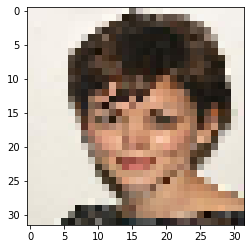

In [16]:
x = wmtestset[50][0].numpy()
y = np.transpose(x, (1, 2, 0))
plt.imshow(y)